# Кросс-валидация на реальных данных 

Полезные ссылки: 
- [Пайплайны в sklearn (документация)](https://scikit-learn.org/1.5/modules/generated/sklearn.pipeline.Pipeline.html)
- [Пайплайны в sklearn (youtube)](https://www.youtube.com/watch?v=jzKSAeJpC6s)
- [Кросс-валидация в sklearn (на русском)](https://scikit-learn.ru/stable/modules/cross_validation.html)

Дополнительные материалы:
- [Кросс-валидация (Яндекс.образование)](https://education.yandex.ru/handbook/ml/article/kross-validaciya)


In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import  tqdm

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error


## Подготовка данных

И снова здравствуйте, Малые Кармакулы

In [121]:
df = pd.read_csv('EDA_demo_data/karmakuly_processed.csv', parse_dates=['Date'], index_col='Date')
df.head()

#df = df['2015':]

print ('df shape with nans: ', df.shape)
df = df.drop (['tg', 'td', 'psl'], axis=1)
df = df.dropna()
print ('df shape without nans: ', df.shape)
df.head()



df shape with nans:  (163632, 12)
df shape without nans:  (128354, 9)


,tcc,lcc,wdir,wvel,wgust,prec,ta,rh,ps
Date,,,,,,,,,
1976-11-30 18:00:00,3.0,0.0,110.0,27.0,30.0,0.0,-22.6,88.0,1003.7
1976-11-30 21:00:00,2.0,0.0,120.0,25.0,28.0,0.0,-22.8,85.0,1003.4
1976-12-01 00:00:00,0.0,0.0,110.0,23.0,28.0,0.0,-22.9,85.0,1003.6
1976-12-01 03:00:00,0.0,0.0,100.0,26.0,30.0,0.0,-23.3,86.0,1002.8
1976-12-01 06:00:00,3.0,0.0,110.0,27.0,31.0,0.0,-23.3,85.0,1002.3


## Порождение дополнительных признаков

<Axes: title={'center': 'day_pos (diurnal cycle)'}, xlabel='Date'>

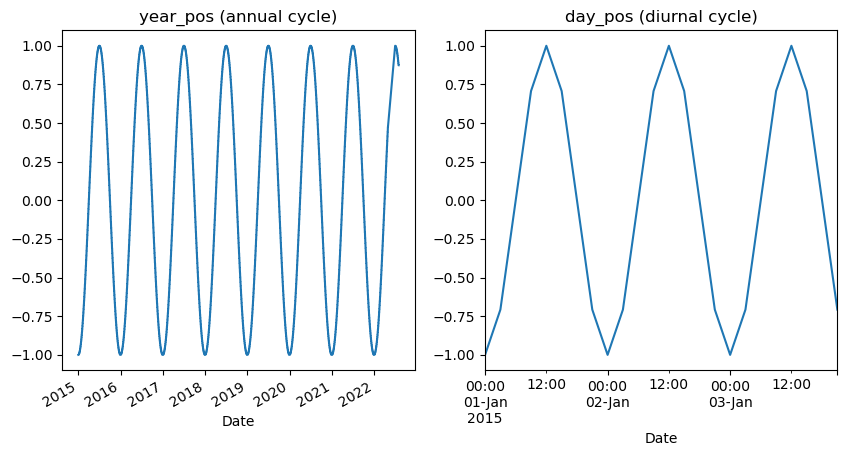

In [3]:
df['year_pos'] = np.cos (np.pi + 2 * np.pi * df.index.dayofyear/365)
df['day_pos']  = np.cos (np.pi + 2 * np.pi * df.index.hour/24)

fig, ax = plt.subplots (1,2, figsize=(10,5))

df['2015':]['year_pos'].plot(ax = ax[0], title='year_pos (annual cycle)')
df['2015-01-01':'2015-01-03']['day_pos'].plot(ax = ax[1], title='day_pos (diurnal cycle)')

## Обучение и проверка модели 

Для начала посмотрим на оценки, если обучать и проверять модель на одних и тех же данных

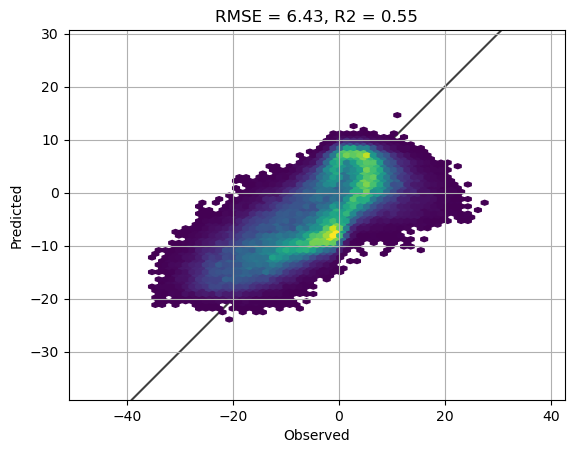

In [ ]:
def evaluate_model (model, X, y):
       y_pred = model.predict(X)

       plt.figure()

       plt.hexbin (y, y_pred, mincnt=1, gridsize=50)

       plt.axis('equal')
       ax = plt.gca()
       lims = [
              np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
              np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
              ]
       plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
       plt.xlim(lims)
       plt.ylim(lims)
       plt.grid()
       plt.xlabel('Observed')
       plt.ylabel('Predicted')

       r = np.corrcoef(y_pred, y)[0,1]
       r2 = r2_score(y, y_pred)
       mse = mean_squared_error(y, y_pred)

       plt.title ('RMSE = %.2f, R2 = %.2f'%(np.sqrt (mse), r2))

target_var = 'ta'

y = df[target_var]
X = df.drop(target_var, axis=1)

model = Pipeline([
                ('scaler', StandardScaler()),
                ('regressor', LinearRegression())
                ])

model.fit(X, y)
evaluate_model (model, X, y)



## Кросс-валидация штатными средствами sklearn №1

Используем функцию [cross_val_score](https://scikit-learn.org/1.5/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score)

In [ ]:
from sklearn.model_selection import ShuffleSplit, KFold, GroupKFold

#cv = ShuffleSplit(n_splits=10, test_size=0.25, random_state=0)
cv = KFold (n_splits=10)

scores = cross_val_score (model, X, y, cv=cv, scoring='neg_root_mean_squared_error')

display(scores)

print ('score mean: ', scores.mean()) 
print ('score std: ', scores.std()) 

score mean:  -6.448899747583158
score std:  0.49784019627198633


## Кросс-валидация штатными средствами sklearn №2

Теперь используем более продвинутую функцию [cross_validate](https://scikit-learn.org/1.5/modules/generated/sklearn.model_selection.cross_validate.html)

In [91]:
scores = cross_validate (model, X, y, cv=cv, scoring=['neg_root_mean_squared_error', 'r2'], return_train_score = True)

In [93]:
display(scores)

{'fit_time': array([0.08482337, 0.04944134, 0.05161762, 0.06395626, 0.06466603,
        0.06597853, 0.08026266, 0.07339954, 0.06897449, 0.06235814]),
 'score_time': array([0.00199533, 0.00322056, 0.00191665, 0.00405669, 0.00393438,
        0.0029819 , 0.00400019, 0.00355816, 0.00444365, 0.00444698]),
 'test_neg_root_mean_squared_error': array([-7.67936284, -6.60432972, -6.89657321, -5.99643712, -6.40121825,
        -6.45113137, -6.07787576, -6.26281666, -5.89009037, -6.22916218]),
 'train_neg_root_mean_squared_error': array([-6.28018342, -6.40804105, -6.37498071, -6.47412646, -6.43256354,
        -6.42561005, -6.4671489 , -6.447291  , -6.48922198, -6.45012782]),
 'test_r2': array([0.47439811, 0.53519064, 0.55009017, 0.60664837, 0.57445738,
        0.56767656, 0.50314554, 0.49844287, 0.49837909, 0.53247345]),
 'train_r2': array([0.55872701, 0.55606303, 0.55312234, 0.54803253, 0.54882588,
        0.55215019, 0.55643279, 0.55803946, 0.55536398, 0.55499578])}

In [97]:
print ('score mean (train): ', -scores['train_neg_root_mean_squared_error'].mean()) 
print ('score mean (test): ',  -scores['test_neg_root_mean_squared_error'].mean()) 

print ('score std (train): ', scores['train_neg_root_mean_squared_error'].std()) 
print ('score std (test): ', scores['test_neg_root_mean_squared_error'].std()) 

score mean (train):  6.4249294919798725
score mean (test):  6.448899747583158
score std (train):  0.05767287379010681
score std (test):  0.49784019627198633


## Посмотрим подробнее, как устроено разбиение train/test

In [ ]:
cv = ShuffleSplit(n_splits=5, test_size=0.25, random_state=0)
#cv = KFold(n_splits=5)
#cv = BlockedKFold (n_splits=5, block_size = 10000)

is_train4folds = pd.DataFrame(index = df.index)

for i, (train_index, test_index) in enumerate(cv.split(X)):
    is_train = np.zeros(df.index.shape)
    is_train[train_index] = 1     
    is_train4folds[i] = is_train 


102354 26000 0
102354 26000 0
102354 26000 0
102354 26000 0
104001 24353 0


<Axes: xlabel='Date'>

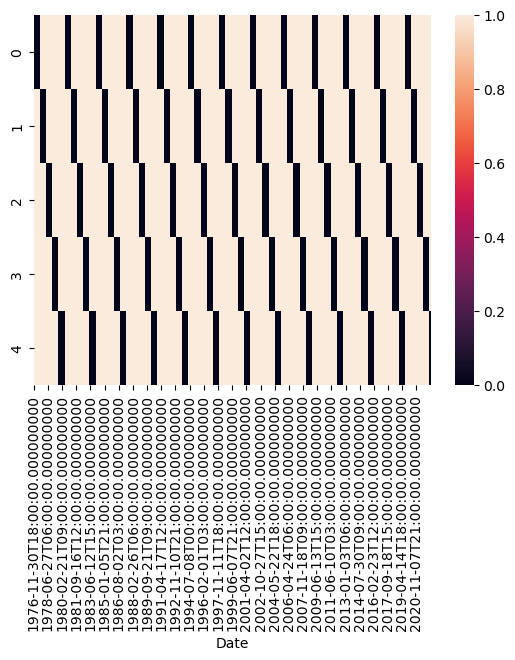

In [120]:
import seaborn as sns
sns.heatmap (is_train4folds.T) 

## Создаем собственный генератор, разделяющий выборку на train/test  

См. подробнее про [генераторы в Python на примере скатерти-самобранки](https://habr.com/ru/articles/560300/)

In [ ]:
class BlockedKFold:
    def __init__(self, n_splits=3, block_size = 500):
        self.n_splits = n_splits
        self.block_size = block_size
        self.splits = None
    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits
    def split(self, X, y=None, groups=None):
        n_samples = len(X)

        fold_size = self.block_size // self.n_splits
        block_start_idx = np.arange(0, n_samples, self.block_size)
        
        for i in range(self.n_splits):
            test_idx = []
            for block_start in block_start_idx:
                start = block_start + i * fold_size
                end = np.min([n_samples-1, block_start + (i + 1) * fold_size])
                test_idx.extend(list(range(start, end)))
            train_idx = list(set(range(n_samples)) - set(test_idx))

            train_idx = np.array(train_idx)
            test_idx = np.array(test_idx)
            
            #print (len(train_idx), len(test_idx), n_samples - len(test_idx) - len(train_idx))

            yield train_idx, test_idx